In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans



# Begin exploration

In [102]:
all_data = pd.read_csv('data/manchester_data.csv').set_index('geo_code_lsoa')

In [103]:
all_data.head()

,local_auth,age_mean,badhealth,centheat,nodepr,studenthhold,nocars,eth_hhi,centre_dummy,centre,depr_dummy
geo_code_lsoa,,,,,,,,,,,
E01005268,Manchester,40.40783,0.042121,0.976861,0.509054,0.001006,0.280684,0.285152,1.0,Yes,1.0
E01033656,Manchester,22.29914,0.003438,0.909330,0.371879,0.268068,0.674113,0.361815,1.0,Yes,0.0
E01005184,Manchester,29.31636,0.031117,0.966624,0.441592,0.219512,0.410783,0.159142,1.0,Yes,0.0
E01005298,Manchester,30.76403,0.041417,0.973479,0.483619,0.015601,0.260530,0.064515,1.0,Yes,0.0
E01005300,Manchester,36.61435,0.051249,0.977551,0.404082,0.004082,0.159184,0.060058,1.0,Yes,0.0


In [104]:
tokeep = ['age_mean', 'badhealth', 'centheat', 'studenthhold', 'nocars', 'eth_hhi', 'depr_dummy']

man_data = all_data[tokeep]

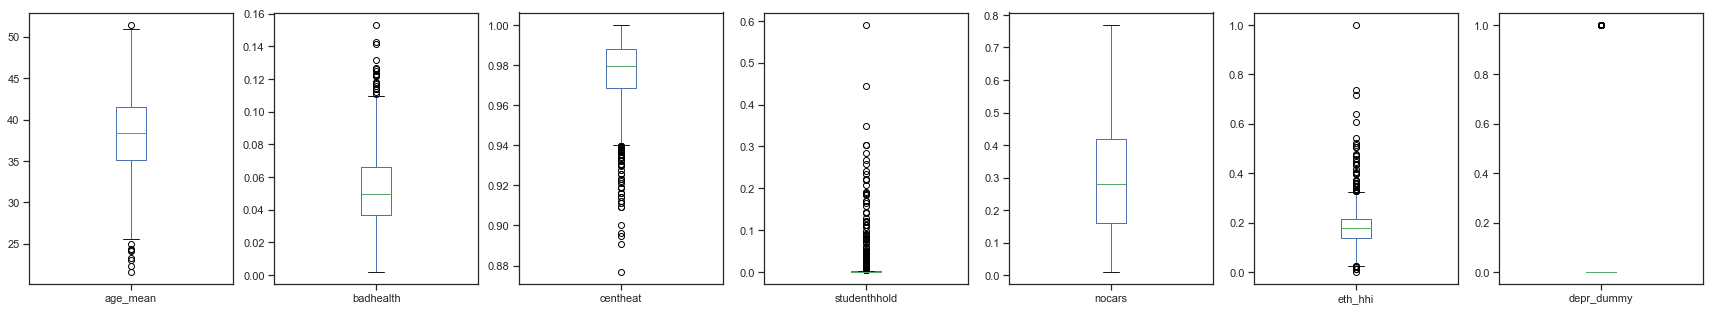

In [105]:
# box plots
man_data.plot(kind='box', subplots=True, figsize=(30, 5))
plt.show()

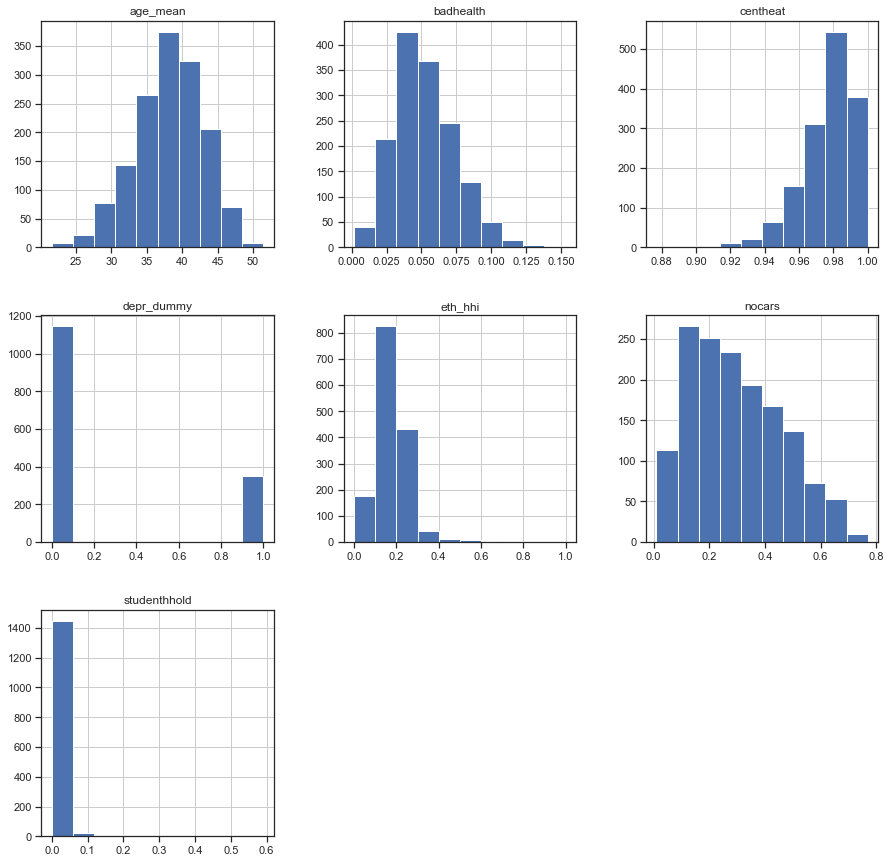

In [106]:
# Show histogram of each feature
man_data.hist(figsize=(15, 15))
plt.show()

# this should show all of them??

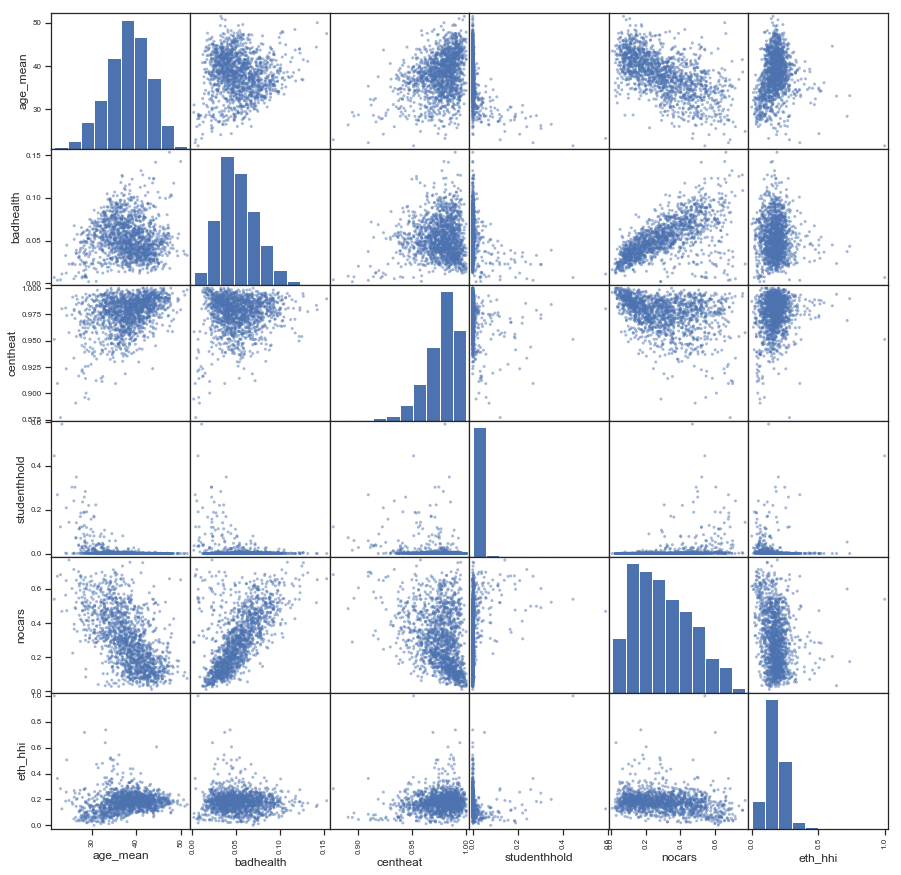

In [107]:
#Display a scatter matrix
pd.plotting.scatter_matrix(man_data.drop('depr_dummy', axis = 1), diagonal = 'hist',  figsize=(15, 15))
plt.show()

C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\gylk\AppData\Local\Continuum\anaconda3\envs\gds\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


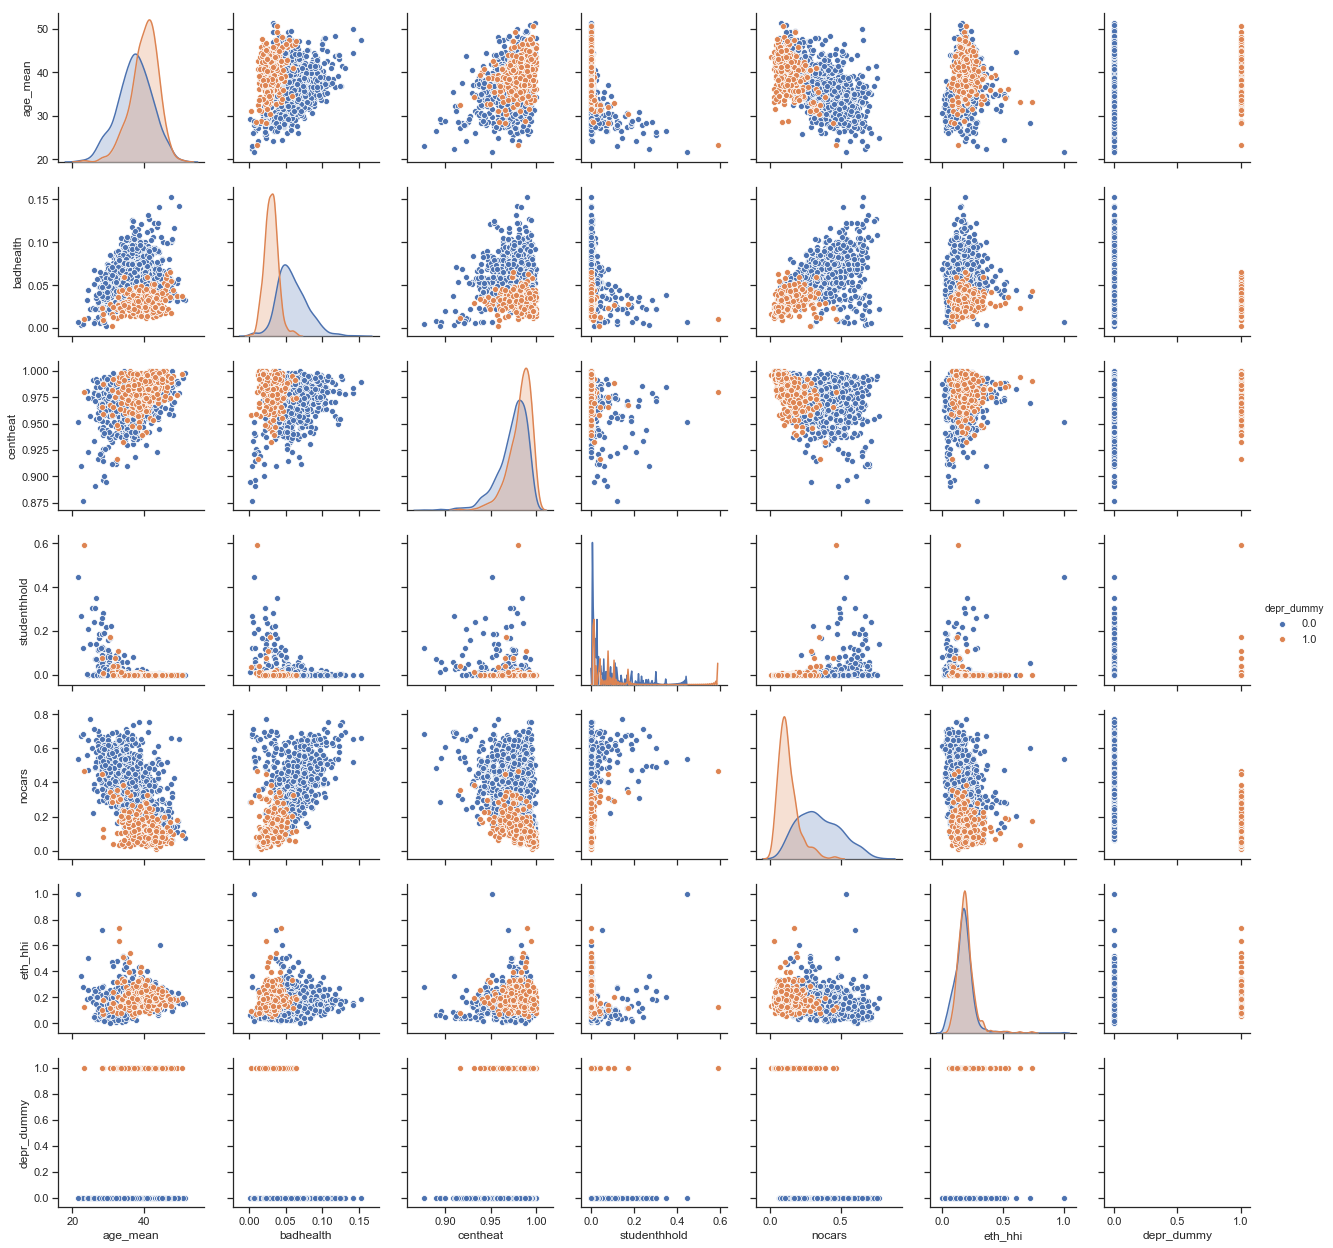

In [108]:
sns.set(style="ticks")
sns.pairplot(man_data, hue = 'depr_dummy')

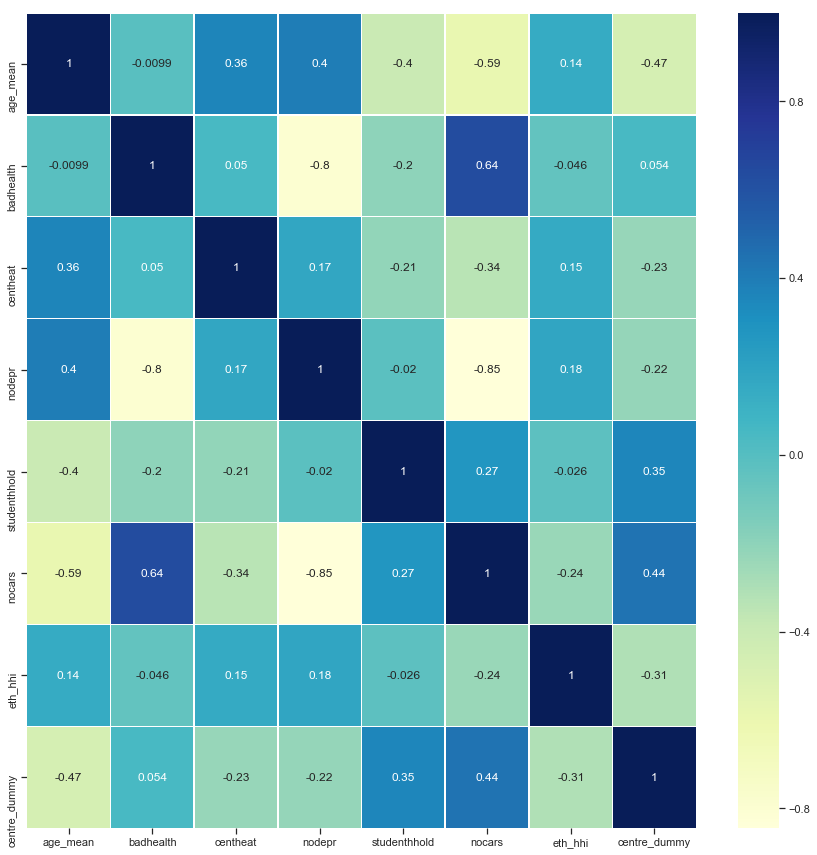

In [56]:
axsns = plt.subplots(figsize=(15, 15))
sns.heatmap(man_data.corr(), annot=True, linewidths=.5, cmap="YlGnBu")
plt.show()

# PCA

In [109]:
# Convert data to array
data = man_data.iloc[:,:-1].values

In [110]:
# Perform PCA
pca = PCA(n_components=None) # Create an instance of the PCA class
"""
    We dont specify the amount of components to reduce to yet 
    as we want to see how many Princible Components explain the most varience in 
    the dataset
"""
pcaResults = pca.fit_transform(data) # Fit the data to the model
explained_variance = pca.explained_variance_ratio_ # Extract the varience

In [111]:
print(np.around(explained_variance,3) )

[0.999 0.001 0.    0.    0.    0.   ]


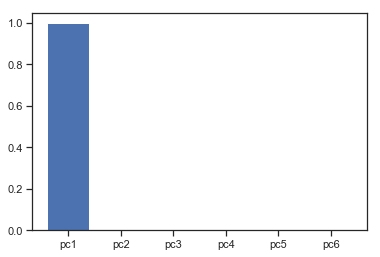

In [113]:
# Plot the explained varience
pcaComponents = ['pc1','pc2','pc3','pc4','pc5','pc6']
y_pos = np.arange(len(pcaComponents))
plt.bar(y_pos, explained_variance)
plt.xticks(y_pos, pcaComponents)
plt.show()

In [114]:
# perform pca

# Convert data to array
data =  df.iloc[:,2:-2].values

# Perform PCA
pca = PCA(n_components=2) # Now specify 2 components
results = pca.fit_transform(data)

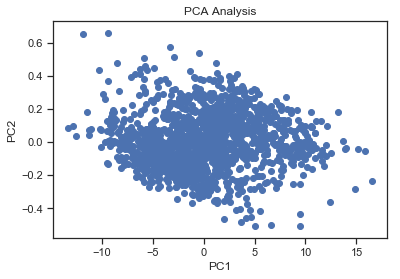

In [115]:
# Show Plot
plt.scatter(results[:,0], results[:,1])
plt.title('PCA Analysis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [66]:
# Define Color map
colour_map = {
    'Manchester': 'red',
    'Tameside' : 'blue',
    'Stockport' : 'green',
    'Trafford' : 'yellow',
    'Bury' : 'orange',
    'Rochdale' : 'purple',
    'Wigan' : 'grey',
    'Salford' : 'black',
    'Oldham' : 'brown'
}

In [116]:
# Define Color map
colour_map = {
    float(0) : 'red',
    float(1) : 'blue'
}

In [117]:
# Create an array of colours based on the target column
colours = [colour_map[c] for c in man_data['depr_dummy']]

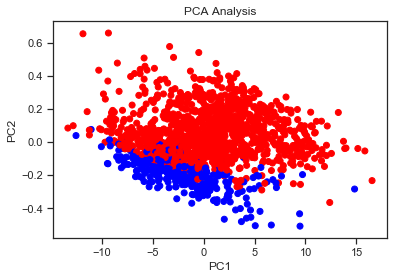

In [118]:
# Show Plot
plt.scatter(results[:,0], results[:,1], c=colours)
plt.title('PCA Analysis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# K-means on PCA Data

In [119]:
# use the elbow method
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(results)
    wcss.append(kmeans.inertia_)

In [120]:
"""
    K-Means parameters 
    n_clusters = the number of clusters
    init = the method for placing initial centroids
    max_iter = the maximum amount of iterations
    n_init = the number of times that K-means is run with different random centroids
    random_state = the seed value
"""
# use the elbow method
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(results)
    wcss.append(kmeans.inertia_)

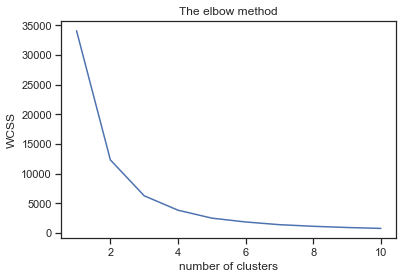

In [121]:
# Plot the WCSS results
plt.plot(range(1,11), wcss)
plt.title('The elbow method')
plt.xlabel('number of clusters')
plt.ylabel('WCSS')
plt.show()

In [122]:
# Apply K-means to petal data based on WCSS results
kmeans = KMeans(n_clusters=3, init = 'k-means++', max_iter=300, n_init=10, random_state=0)

# this will create an arry for the predicted clusters for the petal data
y_kmeans = kmeans.fit_predict(results)

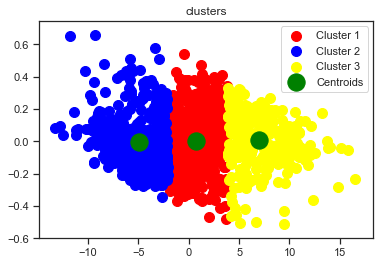

In [123]:
# Visualise the clusters
# Specify that we want the observation in X where the cluster == 0

"""
    X               = The dataset 
    [y_kmeans==0    = Where the cluster == 0 - uses the index of y-kmeans to selected rows from x
    , 0]            = The first column in the dataset
    s = 100         = The size of the points
    c = 'red'       = The color of the cluster
"""
plt.scatter(results[y_kmeans==0, 0], results[y_kmeans==0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(results[y_kmeans==1, 0], results[y_kmeans==1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(results[y_kmeans==2, 0], results[y_kmeans==2, 1], s=100, c='yellow', label='Cluster 3')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=300, c='green', label='Centroids')
plt.title('clusters')
plt.legend()
plt.show()